# Denoising Autoencoder

Dies ist ein Tutorial zur Erstellung eines einfachen Denoising Autoencoders in Python mit Hilfe von Tensorflow.

Die Implementierung wurde angelehnt an [Tensorflow Project: Auto-Encoder Example](https://github.com/aymericdamien/TensorFlow-Examples/blob/master/notebooks/3_NeuralNetworks/autoencoder.ipynb)

## Kurze  theoretische Einführung
Ein Denoising Autoencoder (im Folgenden _DAE_ genannt) erlernt die Fähigkeit eine korrupte Eingabe zu einem gewissen Grad wieder herzustellen.
Im Allgemeinen kann der Rekonstruktionsablauf einer Eingabe bei einem genrellen Autoencoder wie folgt beschrieben werden:
    $$x' = decode(encode(x))$$
dabei ist $x$ der Eingabevektor und $x'$ der Ausgabevektor. Ein DAE funktioniert im Gebraucht genauso, allerdings muss für das Training die Korruption manuell vorgenommen werden, und somit, der Rekonstruktionsablauf angepasst werden:
    $$x' = decode(encode(corrupt(x)))$$
dabei ist $corrupt(x)$ eine Funktion die z. B. Gaußsches Rauschen (engl. _gaussian noise_) zur Eingabe hinzufügt um sie zu korrumpiern. Der Lerneffekt erfolgt nun daraus, dass die Rekonstruktion $x'$ nicht mit $corrupt(x)$, sondern mit der originalen Eingabe $x$ verglichen wird. Diese zusätzliche Bedingung resultiert in einer robusteren Rekonstruktionsfunktion.

## Implementierung mit Tensorflow
Zu Beginn werden einige Bibliotheken importiert, mitunter Tensorflow
* **Tensorflow**: Erlaubt die einfache Realisierung von neuronalen Netzwerken
* **Numpy**: Stellt Funktionen zu sämmtlichen mathematischen Verfahren und multidimensionalen Matrizen zur Verfügung
* **Matplotlib**: Eine Bibliothek zum Erstellen von Graphen oder Anzeigen von Bildern

In [40]:
from __future__ import division, print_function, absolute_import

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

Es werden allerdings auch Trainingsdaten benötigt. Für dieses Beispiel soll der DAE lernen Ziffern von 0 - 9 zu rekonstruieren. Dafür bietet sich der MNIST-Datensatz an, der über 60,000 Exemplare handgeschriebener Ziffern enthält die die Dimension 28x28 besitzen.

In [41]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Extracting /tmp/data/train-images-idx3-ubyte.gz
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


Einige Voreinstellungen müssen noch gemacht werden, damit der DAE sich erwartungsgemäß funktioniert. Dafür müssen folgende Parameter initialisiert werden:
* **`learing_rate`**: Die Lernrate muss ausreichend getestet werden, da eine zu hohe Lernrate ein Umspringen der Gewichtungen zur Folge hat und kein Lerneffekt erfolgt und eine zu niedrige Lernrate den Lernprozess unnötig verlangsamt. Die Lernrate ist der Wert den der Backpropagation Algorithmus verwendet, um die Gewichte je nach Verlust anzupassen. Für dieses Beispiel bietet ein Wert zwischen 0.04 und 0.035 die besten und schnellsten Ergebnisse.
* **`num_epochs`**: Die Anzahl der Epochen die Durchlaufen werden. Eine Epoche wird erreicht, wenn einmal die gesamte Testmenge durchlaufen wurde. Für dieses Beispiel wird nach 25 - 30 Epochen ein ausreichend kleiner Verlust erreicht.
* **`batch_size`**: Die Batch Size ist die Anzahl der Trainingsdaten für die ein Verlust berechnet und eine Backpropagation durchgeführt wird. Diese sollte nicht zu hoch, allerdings auch nicht zu niedrig sein. Je nach Veränderung der Batch Size muss auch die Lernrate und die Anzahl der Epochen angepasst werden.
* **`num_display_iterations`**: Dieser Parameter dient zur Visualisierung des Lernprozesses und gibt an wie viele Iterationen ausgegeben werden sollen. Eine Iteration ist das Lernen einer Batch und gibt den Verlust aus.
* **`num_tests`**: Dieser Parameter dient ebenfalls der Visualisierung und der Überwachung des Lernfortschritts. Er gibt an wie viele Tests gemacht werden sollen. Ein Test ist so wie das Training, nur, dass hierbei die Daten aus der Testmenge anstatt der Trainingsmenge verwendet werden und die Daten nicht gelernt, sondern nur verarbeitet werden. Ein Test erfolgt nach einer ganzen Epoche. Diese Anzahl sollte vorzugsweise ein gemeinsamer Teiler von der Anzahl der Epochen sein.

In [42]:
learning_rate = 0.04
num_epochs = 200
batch_size = 200
num_display_iterations = 2
num_tests = 20

Als nächstes werden die Dimensionen der einzelnen Schichten des Netzes definiert. Wie bei einem Autoencoder üblich, ist die verdeckte Schicht von niedrigerer Dimension als die anderen. Die verdeckte Schicht kann natürlich auch eine viel höhere Dimension annehmen, mehr Neuronen zur Verfügung zu haben, die auf bestimmte Aspekte der Eingabe wert legen. Eine höhere Dimension bedeuetet allerdings auch eine deutlich erhöhte Laufzeit, was für gewöhnliche Rechner kaum tragbar wäre. Also soll das Sparsity Constraint der geringeren Anzahl von Neuronen in der verdeckten Schicht für dieses Beispiel genügen.

Des Weiteren sollte angemerkt werden, dass dieses Beispiel zwei verdeckte Schichten besitzt, aus welchem Grund es auch die beiden Parameter `num_hidden_1` und `num_hidden_2` gibt, wobei die der Wert von `num_hidden_2` die endgültige Dimension der verdeckten Schicht angibt. Diese Aufteilung in mehrere latente Repräsentionen erlaubt das Erlernen von unterschiedlichen Merkmalen, die dann von Schicht zu Schicht weiter verfeinert werden. Die Variable `num_input` beschreibt die Dimension der Eingabe- und folglich auch der Ausgabeschicht. Der Wert 784 ergibt sich aus den Dimensionen der Daten im MNIST-Datensatz, dessen Bilder die Abmessungen 28x28 besitzen, was in einer gesamten Pixelanzahl von 784 resultiert. 784 Pixel werden also in diesem Beispiel auf eine Repräsentation von nur 128 Pixel reduziert.

In [43]:
num_hidden_1 = 256
num_hidden_2 = 128
num_input = 784

Mit den Dimensionen definiert, können nun die Gewichtematrizen und die Biasvektoren erstellen. Da es zwei verdeckte Schichten gibt, besteht der Encoder, sowie der Decoder ebenfalls aus zwei Schichten. Von den Dimesnionen her wird erst von `num_input` auf `num_hidden_1` und dann auf `num_hidden_2` abgebildet und für den Decoder folglich umgekehrt. Die Matrizen und Vektoren werden mit zufälligen Werten initialisiert, indem sie durch `tf.random_normal()` die Werte einer zufälligen Normalverteilung zugewiesen bekommen.

In [44]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([num_input, num_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_hidden_2])),
    'decoder_h1': tf.Variable(tf.random_normal([num_hidden_2, num_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([num_hidden_1, num_input])),
}
biases = {
    'encoder_b1': tf.Variable(tf.random_normal([num_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([num_hidden_2])),
    'decoder_b1': tf.Variable(tf.random_normal([num_hidden_1])), 
    'decoder_b2': tf.Variable(tf.random_normal([num_input])),
}

Für das manuelle Korrumpieren der Daten wird auch eine entsprechende Funktion benötigt. In diesem Beispiel wird die Eingabe mit Gaußschem Rauschen maskiert, sodass das Bild nicht mehr so leicht erkennbar ist. Dafür wird zuerst ein Rauschen `noise` erzeugt, indem auch hier wieder ein Array eier zufälligen Normalverteilung mit `np.random.normal(mean, stddev, size)` generiert wird. Der Wert für `stddev` beschreibt die Intensität des Rauschens, also je höher die Standardabweichung, desto schwerer ist das Bild zu erkennen. Für dieses Beispiel wurde der Wert 0,2 gewählt, da für höhere Werte auch deutlich mehr Epochen gebraucht werden, bis der DAE eine ordentliche Rekonstruktion lernt. Das Array `noise` wird am Schluss einfach additiv dem Eingabevektor hinzugefügt um ihn zu maskieren.

Numpy wird hier gegenüber Tensorflow bevorzugt, da die Visualisierung der korrupten Daten, also das Anzeigen als Bild am Ende des Programms damit deutlich einfacher funktioniert.

In [45]:
def corrupt(x):
    noise = np.random.normal(0, 0.2, 784)
    return x + noise

Als nächstes werden die Funktionen zum Erstellen des Encoders und des Decoders eingeführt. Als Aktivierungsfunktion der einzelnen Neuronen wird die Sigmoidfunktion verwendet. Als erstes wird der Eingabevektor `x` mit der Gewichtungsmatrix `weights['encoder_h1']` multipliziert, indem `tf.matmul()` mit beiden Parametern angewerndet wird. Dies resultiert in einem Vektor, welcher anschließend mit Hilfe von `tf.add()` mit dem Biasvektor `encoder_b1` addiert wird (Dieser Schitt wird weggelassen, sofern keine Biasvektoren verwendt werden). Dieser Ergebnisvektor wird nun in die Sigmoidfunktion `tf.nn.sigmoid()` eingegeben um die jeweiligen Aktivierungen und damit die Ausgabewerte für die erste Schicht des Encoders `layer_1` zu erhalten. Dies wird entsprechend auch für die zweite Schicht `layer_2` gemacht, welcher den endgültigen Ausgabevektor für den Encoder darstellt. Korrespondierend wird dies auch für den Decoder angewendet.

In [46]:
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

def decoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2

Um nun das Model zu konstruieren, werden die obigen Funktionen eingesetzt. 
* **`X`**: Dies ist der Eingabevektor, also auch der Eingangsvektor in diesem Tensorflow Graphen. Da es in disem Beispiel keine Funktion dafür gibt, wird hier der Eingabevektor manuell definiert, indem ein `tf.placeholder()` Array mit der Dimensionn `num_input` generiert wird. Es ist ein Placeholder, weil er zur Zeit keine Daten beinhaltet, da die Daten dynamisch von einer Trainingsmenge kommen sollen. 
* **`Z`**: Für die verdeckte Schicht `Z` kommt `enncoder()` zum Einsatz. Allerdings macht sich hier der DAE mit seiner Besonderheit bemerkbar. Anstatt die Originaldaten in den Encoder einzugeben, korrumpieren wir sie vorher, damit der DAE lernt mit korrupten Daten umzugehen.
* **`Y`**: Dies ist die Ausgabeschicht $x'$ aus der Einführung. Da dies die dekodierende Schicht ist, wird hier `decode()` verwendet, um die entsprechende Schicht zuzuweisen. Als Eingabe wird die latente Schicht `Z` verwendet, also `encode(corrupt(X))`. Damit entspricht der Aufbau des Modells (mit einer Variablenumbenennung), der obigen Definition:
    $$x' = decode(encode(corrupt(x)))$$
    
Zusammen ergibt dieses Model nun das neuronale Netzwerk des DAE.

Zu beachten ist, dass bei der Verwendung mit richtigen korrumpierten Daten, der Korrumptionsschritt entfernt werden muss, da die Daten nicht mehr manuell korrumpiert werden müssen.

In [47]:
X = tf.placeholder("float", [None, num_input])
Z = encoder(corrupt(X))
Y = decoder(Z) 

Das Model benötigt für das Training allerdings noch eine Verlustfunktion. In disem Beispiel ist es der mittlere quadratische Fehler. Zunächst wird der Vektor mit den Originaldaten `X` mit dem Ergebnisvektor `Y`, der die Rekonstruktion enthält, subtrahiert, um die Differenz der beiden Vektoren zu bestimmen. Anschließend wird das Ergebnis mit `tf.pow()` quadriert (die 2 gibt den Exponenten an). Danach bestimmt `tf.reduce_mean()` den Mittelwert/Durchschnitt. Diesen Verlust gilt es nun zu minimieren. Dafür stellt Tensorflow sogenannte Optimizer zur Verfügung, die durch Backpropagation das Netz aufgrund eines Verlustets bestraft. In diesem Beispiel wird die RMS Propagation mit `tf.train.RMSPropOptimizer()` verwendet. Diese nimmt als Parameter die oben definierte `learning_rate`. Da Optimizer einen Verlust zu minimieren versuchen, stellen sie auch die Funktion `minimize()` zur Verfügung, die die Verlustfunktion `loss` als Paramter bekommt.

In [48]:
loss = tf.reduce_mean(tf.pow(X - Y, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(loss)

 Um alle vorher definierten Varaiblen auch zu initialisieren, also in den Tensorflow Graph aufzunehmen, müssen erst ein Initializer `tf.gloabal_varaibles_initializer()` und eine Session erzeugt werden. Mit `sess.run(init)` wird der Initializer innerhalb dieser Seesion ausgeführt.

In [49]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

Nun kommt der wichtigste Teil: Das Training.

Aber zuerst werden noch folgende Variablen benötigt:
* **`train_loss`**: Wird später verwendet um die Verlustwerte des Trainings zu speichern und sie in einem Graph ausgeben zu lassen
* **`test_loss`**: Wie `train_loss` für Verlustwerte der Tests
* **`num_iterations`**: Dies ist die _lokale_ Anzahl der Iterationen, also wie viele Iterationen es innerhalb Epoche gibt. Also ergiebt sich diese Zahl daraus, dass die Anzahl der Trainingsdaten (hier) ganzzahlig durch die Batch Size geteilt wird, da in einer Iteration eine ganze Batch Size verarbeitet wird und eine Verarbeitung als Iteration bezeichnet wird.
* **`absolute_iterations_count`**: Dies ist die _globale_ Anzahl an Iterationen, die bisher erfolgt sind.

Anschließend aber kommt das Training. Hierzu wird über die gesamte Anzahl der Epochen `num_epochs` iteriert. Eine innere Schleife iteriert über die Anzahl lokaler Iterationen `num_iterations` (aus Visualisierungsgründen wird bei beiden Schleifen ab 1 begonnen). Als Erstes werden die Trainingsdaten mit `mnist.train.next_batch(batch_size)` abgerufen und in `batch_x` gespeichert. Anschließend wird mit `sess.run` sowohl `optimizer` und `loss` mit dem Parameter `X` aufgerufen. `X` wird bei `feed_dict={}` die Testdaten in `batch_x` zugewiesen. Der Rückgabewert von `optimizer` wird nicht benötigt, allerdings der von `loss`, da dieser später ausgegeben werden soll. Dieser wird in `l` festgehalten und eine Zeile darunter auch der Liste `train_loss` zugewiesen, um diesen Verlustwert später in einen Graphen einzugeben, der die Veränderung der Verluste während des Traings zeigt. Die Verzweigung darunter entscheidet aufgrund von `num_display_iterations` und den vorher definierten Parametern, ob eine Kontrollausgabe gemacht werden soll. Ähnliches gilt für die Verzweigung unter der inneren Schleife, die entscheidet, ob ein Test durchgeführt werden soll. Nach der ersten Epoche wird unabhängig von `num_epochs` ein Test durchgeführt. Wenn z. B. also `num_epochs = 1`, dann wird nach der ersten und letzten Epoche ein Test durchgeführt. Dies dient allerdings auch nur zur Visialisierung und Kontrolle des Lernprozesses und hat keinen Einfluss auf die erlernten Fähigkeiten (warum es keinen Einfluss hat wird weiter unten erläutert).

(Anmerkung: Die Zelle der Testmethode weiter unten muss zuerst ausgeführt werden, damit der Code funktioniert, da hier die Funktion `TestAE` benutzt wird, die das Programm aber noch nicht kennt.)

Epoch 1:
	Iteration 137  	Loss: 0.272752
	Iteration 274  	Loss: 0.195
Original Images


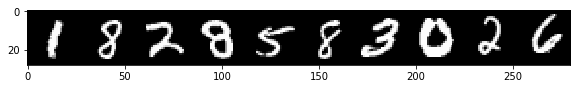

Corrupted Images


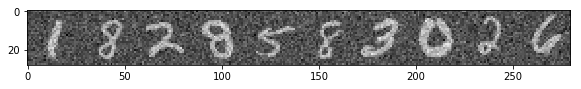

Reconstructed Images


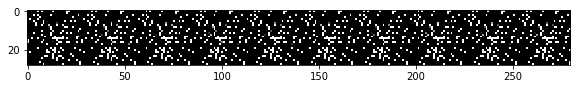

Test loss: 0.198987

Epoch 2:
	Iteration 412  	Loss: 0.117254
	Iteration 549  	Loss: 0.0864926
Epoch 3:
	Iteration 687  	Loss: 0.0718446
	Iteration 824  	Loss: 0.065994
Epoch 4:
	Iteration 962  	Loss: 0.0595379
	Iteration 1099  	Loss: 0.0545044
Epoch 5:
	Iteration 1237  	Loss: 0.0511626
	Iteration 1374  	Loss: 0.0501273
Epoch 6:
	Iteration 1512  	Loss: 0.048932
	Iteration 1649  	Loss: 0.0494625
Epoch 7:
	Iteration 1787  	Loss: 0.0455578
	Iteration 1924  	Loss: 0.0484146
Epoch 8:
	Iteration 2062  	Loss: 0.0468113
	Iteration 2199  	Loss: 0.0468943
Epoch 9:
	Iteration 2337  	Loss: 0.0457107
	Iteration 2474  	Loss: 0.0452404
Epoch 10:
	Iteration 2612  	Loss: 0.0425744
	Iteration 2749  	Loss: 0.0406329
Original Images


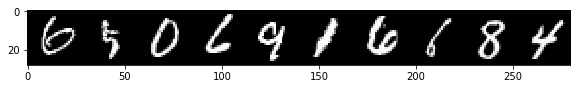

Corrupted Images


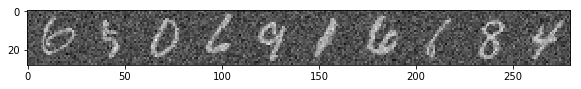

Reconstructed Images


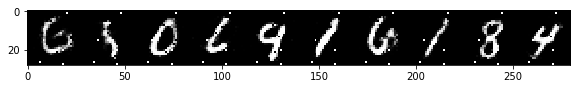

Test loss: 0.0355819

Epoch 11:
	Iteration 2887  	Loss: 0.0425571
	Iteration 3024  	Loss: 0.0391668
Epoch 12:
	Iteration 3162  	Loss: 0.0381747
	Iteration 3299  	Loss: 0.0379714
Epoch 13:
	Iteration 3437  	Loss: 0.0356298
	Iteration 3574  	Loss: 0.0374167
Epoch 14:
	Iteration 3712  	Loss: 0.034105
	Iteration 3849  	Loss: 0.0372324
Epoch 15:
	Iteration 3987  	Loss: 0.0350989
	Iteration 4124  	Loss: 0.0325595
Epoch 16:
	Iteration 4262  	Loss: 0.0344102
	Iteration 4399  	Loss: 0.0338747
Epoch 17:
	Iteration 4537  	Loss: 0.0327484
	Iteration 4674  	Loss: 0.0330018
Epoch 18:
	Iteration 4812  	Loss: 0.0304851
	Iteration 4949  	Loss: 0.0323856
Epoch 19:
	Iteration 5087  	Loss: 0.0326376
	Iteration 5224  	Loss: 0.0327187
Epoch 20:
	Iteration 5362  	Loss: 0.0323692
	Iteration 5499  	Loss: 0.0309884
Original Images


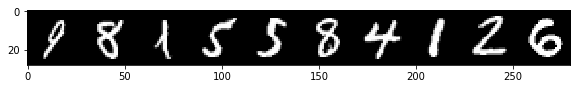

Corrupted Images


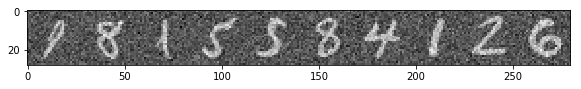

Reconstructed Images


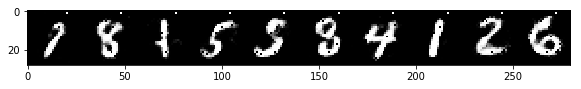

Test loss: 0.0319982

Epoch 21:
	Iteration 5637  	Loss: 0.0330856
	Iteration 5774  	Loss: 0.0329132
Epoch 22:
	Iteration 5912  	Loss: 0.0327463
	Iteration 6049  	Loss: 0.0308283
Epoch 23:
	Iteration 6187  	Loss: 0.0312814
	Iteration 6324  	Loss: 0.0320883
Epoch 24:
	Iteration 6462  	Loss: 0.0314776
	Iteration 6599  	Loss: 0.0316885
Epoch 25:
	Iteration 6737  	Loss: 0.0298463
	Iteration 6874  	Loss: 0.0312488
Epoch 26:
	Iteration 7012  	Loss: 0.030458
	Iteration 7149  	Loss: 0.0294541
Epoch 27:
	Iteration 7287  	Loss: 0.0300996
	Iteration 7424  	Loss: 0.0287021
Epoch 28:
	Iteration 7562  	Loss: 0.0304629
	Iteration 7699  	Loss: 0.031376
Epoch 29:
	Iteration 7837  	Loss: 0.0312539
	Iteration 7974  	Loss: 0.0283935
Epoch 30:
	Iteration 8112  	Loss: 0.0302764
	Iteration 8249  	Loss: 0.0306301
Original Images


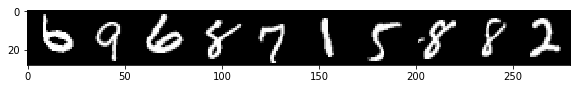

Corrupted Images


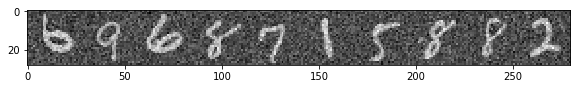

Reconstructed Images


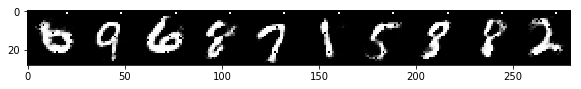

Test loss: 0.0296243

Epoch 31:
	Iteration 8387  	Loss: 0.0291389
	Iteration 8524  	Loss: 0.0305122
Epoch 32:
	Iteration 8662  	Loss: 0.0293326
	Iteration 8799  	Loss: 0.0286987
Epoch 33:
	Iteration 8937  	Loss: 0.0289846
	Iteration 9074  	Loss: 0.0297006
Epoch 34:
	Iteration 9212  	Loss: 0.028876
	Iteration 9349  	Loss: 0.0277979
Epoch 35:
	Iteration 9487  	Loss: 0.0275756
	Iteration 9624  	Loss: 0.0284834
Epoch 36:
	Iteration 9762  	Loss: 0.0275608
	Iteration 9899  	Loss: 0.0271286
Epoch 37:
	Iteration 10037  	Loss: 0.0272355
	Iteration 10174  	Loss: 0.0274226
Epoch 38:
	Iteration 10312  	Loss: 0.0271607
	Iteration 10449  	Loss: 0.0272528
Epoch 39:
	Iteration 10587  	Loss: 0.0259707
	Iteration 10724  	Loss: 0.0254816
Epoch 40:
	Iteration 10862  	Loss: 0.0277565
	Iteration 10999  	Loss: 0.0273089
Original Images


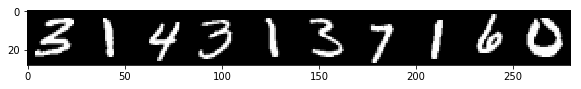

Corrupted Images


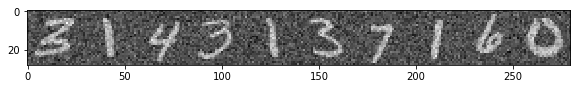

Reconstructed Images


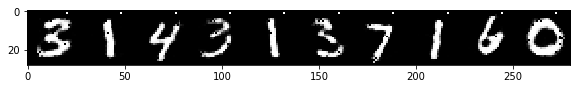

Test loss: 0.026672

Epoch 41:
	Iteration 11137  	Loss: 0.0265129
	Iteration 11274  	Loss: 0.0257254
Epoch 42:
	Iteration 11412  	Loss: 0.0267875
	Iteration 11549  	Loss: 0.0264774
Epoch 43:
	Iteration 11687  	Loss: 0.02533
	Iteration 11824  	Loss: 0.0259212
Epoch 44:
	Iteration 11962  	Loss: 0.0253263
	Iteration 12099  	Loss: 0.028269
Epoch 45:
	Iteration 12237  	Loss: 0.0273161
	Iteration 12374  	Loss: 0.0259345
Epoch 46:
	Iteration 12512  	Loss: 0.0259487
	Iteration 12649  	Loss: 0.0250679
Epoch 47:
	Iteration 12787  	Loss: 0.0247374
	Iteration 12924  	Loss: 0.0254326
Epoch 48:
	Iteration 13062  	Loss: 0.0261084
	Iteration 13199  	Loss: 0.0255218
Epoch 49:
	Iteration 13337  	Loss: 0.0265169
	Iteration 13474  	Loss: 0.0257138
Epoch 50:
	Iteration 13612  	Loss: 0.0254533
	Iteration 13749  	Loss: 0.026864
Original Images


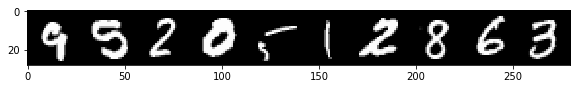

Corrupted Images


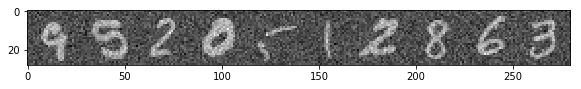

Reconstructed Images


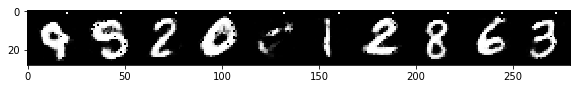

Test loss: 0.0261183

Epoch 51:
	Iteration 13887  	Loss: 0.0249488
	Iteration 14024  	Loss: 0.0263216
Epoch 52:
	Iteration 14162  	Loss: 0.0255111
	Iteration 14299  	Loss: 0.0280545
Epoch 53:
	Iteration 14437  	Loss: 0.0263885
	Iteration 14574  	Loss: 0.0267906
Epoch 54:
	Iteration 14712  	Loss: 0.0252747
	Iteration 14849  	Loss: 0.0274221
Epoch 55:
	Iteration 14987  	Loss: 0.0263583
	Iteration 15124  	Loss: 0.0256908
Epoch 56:
	Iteration 15262  	Loss: 0.0248191
	Iteration 15399  	Loss: 0.0242113
Epoch 57:
	Iteration 15537  	Loss: 0.0248614
	Iteration 15674  	Loss: 0.0255575
Epoch 58:
	Iteration 15812  	Loss: 0.0258785
	Iteration 15949  	Loss: 0.0236609
Epoch 59:
	Iteration 16087  	Loss: 0.0229557
	Iteration 16224  	Loss: 0.0253466
Epoch 60:
	Iteration 16362  	Loss: 0.0263573
	Iteration 16499  	Loss: 0.0264836
Original Images


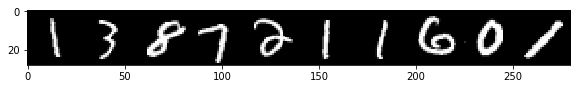

Corrupted Images


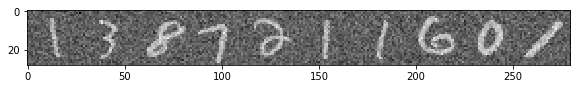

Reconstructed Images


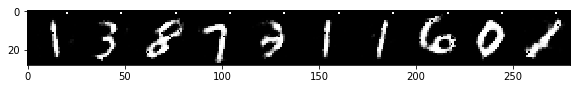

Test loss: 0.0237986

Epoch 61:
	Iteration 16637  	Loss: 0.0244919
	Iteration 16774  	Loss: 0.0253097
Epoch 62:
	Iteration 16912  	Loss: 0.0250218
	Iteration 17049  	Loss: 0.0240926
Epoch 63:
	Iteration 17187  	Loss: 0.0252843
	Iteration 17324  	Loss: 0.0250094
Epoch 64:
	Iteration 17462  	Loss: 0.0245095
	Iteration 17599  	Loss: 0.0250566
Epoch 65:
	Iteration 17737  	Loss: 0.0267805
	Iteration 17874  	Loss: 0.0251118
Epoch 66:
	Iteration 18012  	Loss: 0.0254059
	Iteration 18149  	Loss: 0.022806
Epoch 67:
	Iteration 18287  	Loss: 0.024861
	Iteration 18424  	Loss: 0.0258861
Epoch 68:
	Iteration 18562  	Loss: 0.025598
	Iteration 18699  	Loss: 0.0241453
Epoch 69:
	Iteration 18837  	Loss: 0.0236426
	Iteration 18974  	Loss: 0.024867
Epoch 70:
	Iteration 19112  	Loss: 0.022161
	Iteration 19249  	Loss: 0.0248333
Original Images


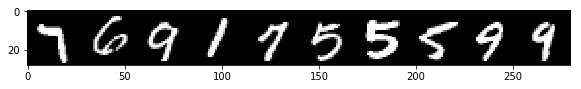

Corrupted Images


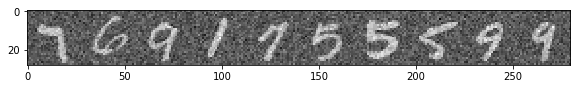

Reconstructed Images


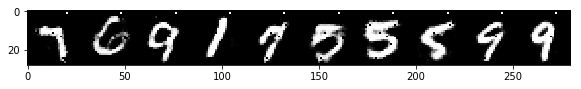

Test loss: 0.0236078

Epoch 71:
	Iteration 19387  	Loss: 0.0229472
	Iteration 19524  	Loss: 0.0237953
Epoch 72:
	Iteration 19662  	Loss: 0.0237427
	Iteration 19799  	Loss: 0.0226062
Epoch 73:
	Iteration 19937  	Loss: 0.022567
	Iteration 20074  	Loss: 0.0233527
Epoch 74:
	Iteration 20212  	Loss: 0.0231173
	Iteration 20349  	Loss: 0.0250074
Epoch 75:
	Iteration 20487  	Loss: 0.0233933
	Iteration 20624  	Loss: 0.0234522
Epoch 76:
	Iteration 20762  	Loss: 0.0226761
	Iteration 20899  	Loss: 0.0233753
Epoch 77:
	Iteration 21037  	Loss: 0.0224682
	Iteration 21174  	Loss: 0.024687
Epoch 78:
	Iteration 21312  	Loss: 0.0241927
	Iteration 21449  	Loss: 0.0240879
Epoch 79:
	Iteration 21587  	Loss: 0.0229566
	Iteration 21724  	Loss: 0.0246145
Epoch 80:
	Iteration 21862  	Loss: 0.0224202
	Iteration 21999  	Loss: 0.0216084
Original Images


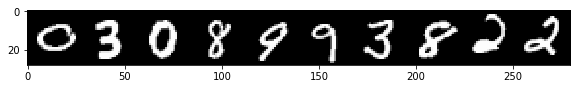

Corrupted Images


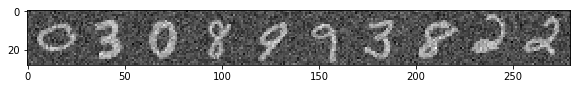

Reconstructed Images


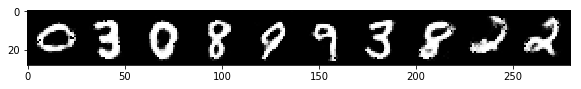

Test loss: 0.0232928

Epoch 81:
	Iteration 22137  	Loss: 0.0216511
	Iteration 22274  	Loss: 0.021829
Epoch 82:
	Iteration 22412  	Loss: 0.0199722
	Iteration 22549  	Loss: 0.021707
Epoch 83:
	Iteration 22687  	Loss: 0.0209736
	Iteration 22824  	Loss: 0.0208167
Epoch 84:
	Iteration 22962  	Loss: 0.0223955
	Iteration 23099  	Loss: 0.0208789
Epoch 85:
	Iteration 23237  	Loss: 0.0227662
	Iteration 23374  	Loss: 0.0219748
Epoch 86:
	Iteration 23512  	Loss: 0.0205651
	Iteration 23649  	Loss: 0.0214242
Epoch 87:
	Iteration 23787  	Loss: 0.022188
	Iteration 23924  	Loss: 0.0205367
Epoch 88:
	Iteration 24062  	Loss: 0.0209386
	Iteration 24199  	Loss: 0.0214349
Epoch 89:
	Iteration 24337  	Loss: 0.0214953
	Iteration 24474  	Loss: 0.0209774
Epoch 90:
	Iteration 24612  	Loss: 0.0205276
	Iteration 24749  	Loss: 0.0217904
Original Images


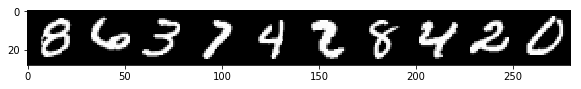

Corrupted Images


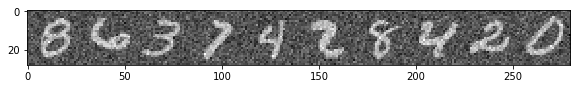

Reconstructed Images


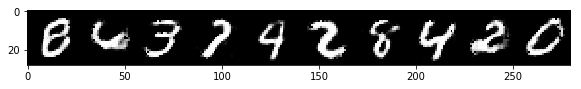

Test loss: 0.0246466

Epoch 91:
	Iteration 24887  	Loss: 0.0209265
	Iteration 25024  	Loss: 0.0199381
Epoch 92:
	Iteration 25162  	Loss: 0.0206788
	Iteration 25299  	Loss: 0.0212273
Epoch 93:
	Iteration 25437  	Loss: 0.0203293
	Iteration 25574  	Loss: 0.0199215
Epoch 94:
	Iteration 25712  	Loss: 0.0205332
	Iteration 25849  	Loss: 0.0214918
Epoch 95:
	Iteration 25987  	Loss: 0.0204477
	Iteration 26124  	Loss: 0.0202275
Epoch 96:
	Iteration 26262  	Loss: 0.0207959
	Iteration 26399  	Loss: 0.0211315
Epoch 97:
	Iteration 26537  	Loss: 0.0206587
	Iteration 26674  	Loss: 0.0206102
Epoch 98:
	Iteration 26812  	Loss: 0.0194526
	Iteration 26949  	Loss: 0.0197017
Epoch 99:
	Iteration 27087  	Loss: 0.019636
	Iteration 27224  	Loss: 0.0201511
Epoch 100:
	Iteration 27362  	Loss: 0.020552
	Iteration 27499  	Loss: 0.0200068
Original Images


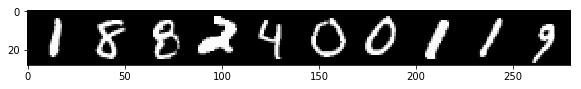

Corrupted Images


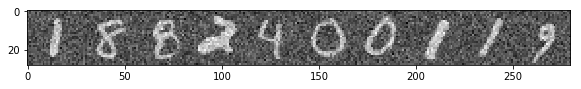

Reconstructed Images


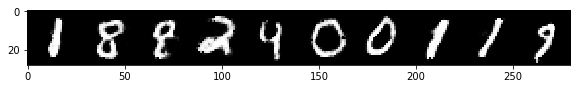

Test loss: 0.0175528

Epoch 101:
	Iteration 27637  	Loss: 0.0194228
	Iteration 27774  	Loss: 0.0203626
Epoch 102:
	Iteration 27912  	Loss: 0.0188548
	Iteration 28049  	Loss: 0.0198267
Epoch 103:
	Iteration 28187  	Loss: 0.0189555
	Iteration 28324  	Loss: 0.0197453
Epoch 104:
	Iteration 28462  	Loss: 0.0192555
	Iteration 28599  	Loss: 0.020756
Epoch 105:
	Iteration 28737  	Loss: 0.0193005
	Iteration 28874  	Loss: 0.0196171
Epoch 106:
	Iteration 29012  	Loss: 0.0187238
	Iteration 29149  	Loss: 0.0195688
Epoch 107:
	Iteration 29287  	Loss: 0.0190724
	Iteration 29424  	Loss: 0.0202789
Epoch 108:
	Iteration 29562  	Loss: 0.0204084
	Iteration 29699  	Loss: 0.0192344
Epoch 109:
	Iteration 29837  	Loss: 0.0187211
	Iteration 29974  	Loss: 0.0192262
Epoch 110:
	Iteration 30112  	Loss: 0.0196501
	Iteration 30249  	Loss: 0.0178099
Original Images


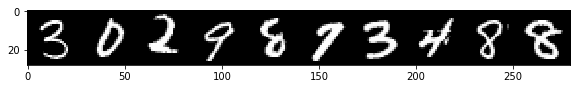

Corrupted Images


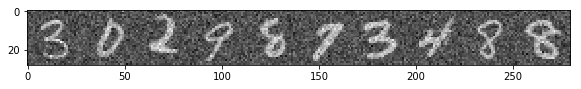

Reconstructed Images


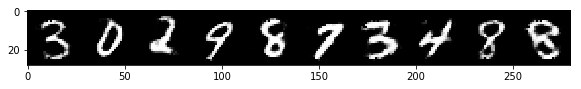

Test loss: 0.0198906

Epoch 111:
	Iteration 30387  	Loss: 0.0198675
	Iteration 30524  	Loss: 0.0194921
Epoch 112:
	Iteration 30662  	Loss: 0.0197052
	Iteration 30799  	Loss: 0.0187654
Epoch 113:
	Iteration 30937  	Loss: 0.0197171
	Iteration 31074  	Loss: 0.0197471
Epoch 114:
	Iteration 31212  	Loss: 0.0192132
	Iteration 31349  	Loss: 0.0205711
Epoch 115:
	Iteration 31487  	Loss: 0.0179775
	Iteration 31624  	Loss: 0.0194355
Epoch 116:
	Iteration 31762  	Loss: 0.0183346
	Iteration 31899  	Loss: 0.0198674
Epoch 117:
	Iteration 32037  	Loss: 0.0187418
	Iteration 32174  	Loss: 0.018367
Epoch 118:
	Iteration 32312  	Loss: 0.0188747
	Iteration 32449  	Loss: 0.0195451
Epoch 119:
	Iteration 32587  	Loss: 0.0202732
	Iteration 32724  	Loss: 0.0187654
Epoch 120:
	Iteration 32862  	Loss: 0.020206
	Iteration 32999  	Loss: 0.0199258
Original Images


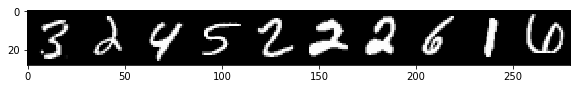

Corrupted Images


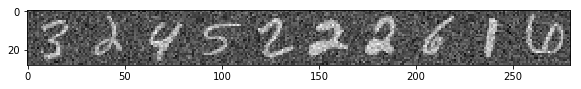

Reconstructed Images


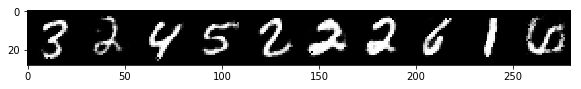

Test loss: 0.0198763

Epoch 121:
	Iteration 33137  	Loss: 0.0185878
	Iteration 33274  	Loss: 0.019651
Epoch 122:
	Iteration 33412  	Loss: 0.0203151
	Iteration 33549  	Loss: 0.0176551
Epoch 123:
	Iteration 33687  	Loss: 0.0186596
	Iteration 33824  	Loss: 0.0173088
Epoch 124:
	Iteration 33962  	Loss: 0.0175037
	Iteration 34099  	Loss: 0.0191884
Epoch 125:
	Iteration 34237  	Loss: 0.0181548
	Iteration 34374  	Loss: 0.0189423
Epoch 126:
	Iteration 34512  	Loss: 0.0185814
	Iteration 34649  	Loss: 0.0185598
Epoch 127:
	Iteration 34787  	Loss: 0.0180117
	Iteration 34924  	Loss: 0.0184554
Epoch 128:
	Iteration 35062  	Loss: 0.0186771
	Iteration 35199  	Loss: 0.0181301
Epoch 129:
	Iteration 35337  	Loss: 0.020057
	Iteration 35474  	Loss: 0.019212
Epoch 130:
	Iteration 35612  	Loss: 0.0191
	Iteration 35749  	Loss: 0.0174015
Original Images


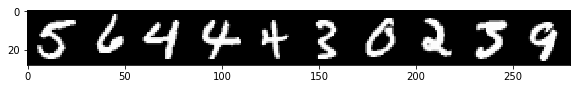

Corrupted Images


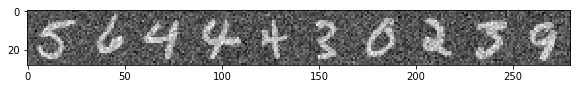

Reconstructed Images


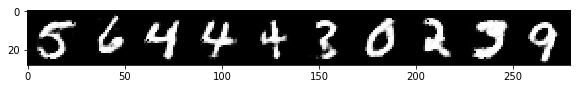

Test loss: 0.0193336

Epoch 131:
	Iteration 35887  	Loss: 0.0187587
	Iteration 36024  	Loss: 0.0187948
Epoch 132:
	Iteration 36162  	Loss: 0.0169915
	Iteration 36299  	Loss: 0.0195891
Epoch 133:
	Iteration 36437  	Loss: 0.0191116
	Iteration 36574  	Loss: 0.0187
Epoch 134:
	Iteration 36712  	Loss: 0.0185816
	Iteration 36849  	Loss: 0.0181624
Epoch 135:
	Iteration 36987  	Loss: 0.0184829
	Iteration 37124  	Loss: 0.0175816
Epoch 136:
	Iteration 37262  	Loss: 0.0175363
	Iteration 37399  	Loss: 0.0192196
Epoch 137:
	Iteration 37537  	Loss: 0.0183004
	Iteration 37674  	Loss: 0.018702
Epoch 138:
	Iteration 37812  	Loss: 0.0177163
	Iteration 37949  	Loss: 0.0179512
Epoch 139:
	Iteration 38087  	Loss: 0.0185032
	Iteration 38224  	Loss: 0.0188654
Epoch 140:
	Iteration 38362  	Loss: 0.0179775
	Iteration 38499  	Loss: 0.0183523
Original Images


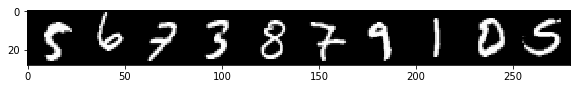

Corrupted Images


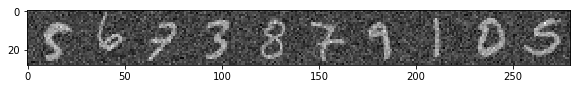

Reconstructed Images


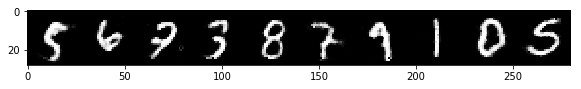

Test loss: 0.0157654

Epoch 141:
	Iteration 38637  	Loss: 0.0178062
	Iteration 38774  	Loss: 0.0177774
Epoch 142:
	Iteration 38912  	Loss: 0.0174056
	Iteration 39049  	Loss: 0.0185632
Epoch 143:
	Iteration 39187  	Loss: 0.0178891
	Iteration 39324  	Loss: 0.0179116
Epoch 144:
	Iteration 39462  	Loss: 0.0180478
	Iteration 39599  	Loss: 0.0176945
Epoch 145:
	Iteration 39737  	Loss: 0.0179322
	Iteration 39874  	Loss: 0.017511
Epoch 146:
	Iteration 40012  	Loss: 0.0174479
	Iteration 40149  	Loss: 0.0180392
Epoch 147:
	Iteration 40287  	Loss: 0.0167467
	Iteration 40424  	Loss: 0.0184827
Epoch 148:
	Iteration 40562  	Loss: 0.0170106
	Iteration 40699  	Loss: 0.0185582
Epoch 149:
	Iteration 40837  	Loss: 0.0177308
	Iteration 40974  	Loss: 0.0182199
Epoch 150:
	Iteration 41112  	Loss: 0.0180645
	Iteration 41249  	Loss: 0.0180856
Original Images


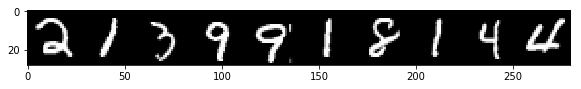

Corrupted Images


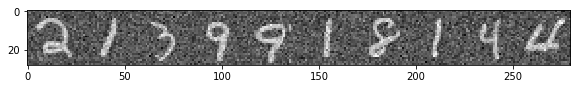

Reconstructed Images


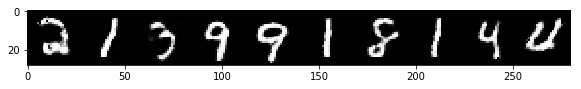

Test loss: 0.0163091

Epoch 151:
	Iteration 41387  	Loss: 0.0179725
	Iteration 41524  	Loss: 0.0193382
Epoch 152:
	Iteration 41662  	Loss: 0.0172044
	Iteration 41799  	Loss: 0.0172443
Epoch 153:
	Iteration 41937  	Loss: 0.0183456
	Iteration 42074  	Loss: 0.0165952
Epoch 154:
	Iteration 42212  	Loss: 0.0173555
	Iteration 42349  	Loss: 0.0193228
Epoch 155:
	Iteration 42487  	Loss: 0.0172487
	Iteration 42624  	Loss: 0.0164634
Epoch 156:
	Iteration 42762  	Loss: 0.0166798
	Iteration 42899  	Loss: 0.0164972
Epoch 157:
	Iteration 43037  	Loss: 0.0175479
	Iteration 43174  	Loss: 0.0168104
Epoch 158:
	Iteration 43312  	Loss: 0.0175068
	Iteration 43449  	Loss: 0.0164381
Epoch 159:
	Iteration 43587  	Loss: 0.017663
	Iteration 43724  	Loss: 0.0168535
Epoch 160:
	Iteration 43862  	Loss: 0.0179149
	Iteration 43999  	Loss: 0.0169308
Original Images


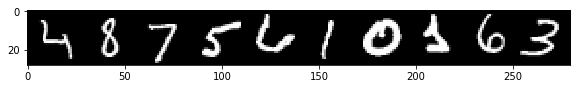

Corrupted Images


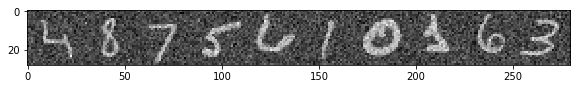

Reconstructed Images


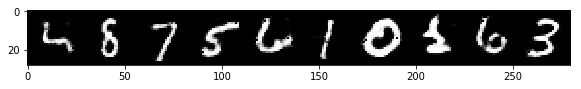

Test loss: 0.0175873

Epoch 161:
	Iteration 44137  	Loss: 0.0162672
	Iteration 44274  	Loss: 0.0169916
Epoch 162:
	Iteration 44412  	Loss: 0.0168744
	Iteration 44549  	Loss: 0.0176499
Epoch 163:
	Iteration 44687  	Loss: 0.0174359
	Iteration 44824  	Loss: 0.0178123
Epoch 164:
	Iteration 44962  	Loss: 0.0174672
	Iteration 45099  	Loss: 0.0172784
Epoch 165:
	Iteration 45237  	Loss: 0.0173129
	Iteration 45374  	Loss: 0.0176511
Epoch 166:
	Iteration 45512  	Loss: 0.0171188
	Iteration 45649  	Loss: 0.0179742
Epoch 167:
	Iteration 45787  	Loss: 0.0175777
	Iteration 45924  	Loss: 0.0170323
Epoch 168:
	Iteration 46062  	Loss: 0.0165142
	Iteration 46199  	Loss: 0.0170482
Epoch 169:
	Iteration 46337  	Loss: 0.0166634
	Iteration 46474  	Loss: 0.0160908
Epoch 170:
	Iteration 46612  	Loss: 0.017168
	Iteration 46749  	Loss: 0.0161091
Original Images


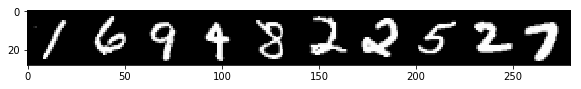

Corrupted Images


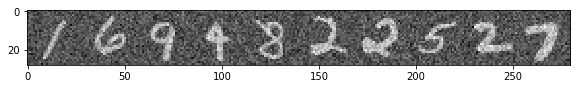

Reconstructed Images


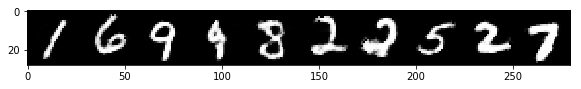

Test loss: 0.0156386

Epoch 171:
	Iteration 46887  	Loss: 0.0159894
	Iteration 47024  	Loss: 0.0157726
Epoch 172:
	Iteration 47162  	Loss: 0.0169513
	Iteration 47299  	Loss: 0.016201
Epoch 173:
	Iteration 47437  	Loss: 0.0158836
	Iteration 47574  	Loss: 0.0161667
Epoch 174:
	Iteration 47712  	Loss: 0.016377
	Iteration 47849  	Loss: 0.01772
Epoch 175:
	Iteration 47987  	Loss: 0.0158177
	Iteration 48124  	Loss: 0.0167439
Epoch 176:
	Iteration 48262  	Loss: 0.017417
	Iteration 48399  	Loss: 0.01627
Epoch 177:
	Iteration 48537  	Loss: 0.0172972
	Iteration 48674  	Loss: 0.0165592
Epoch 178:
	Iteration 48812  	Loss: 0.0163199
	Iteration 48949  	Loss: 0.016444
Epoch 179:
	Iteration 49087  	Loss: 0.0161564
	Iteration 49224  	Loss: 0.0163695
Epoch 180:
	Iteration 49362  	Loss: 0.0169407
	Iteration 49499  	Loss: 0.0176769
Original Images


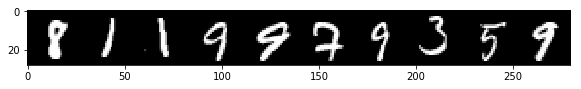

Corrupted Images


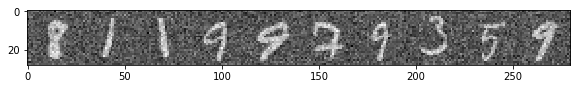

Reconstructed Images


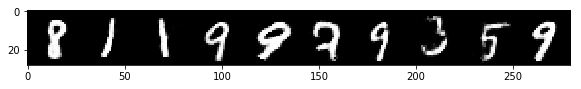

Test loss: 0.0129693

Epoch 181:
	Iteration 49637  	Loss: 0.0173008
	Iteration 49774  	Loss: 0.0166032
Epoch 182:
	Iteration 49912  	Loss: 0.0165264
	Iteration 50049  	Loss: 0.0159856
Epoch 183:
	Iteration 50187  	Loss: 0.0175764
	Iteration 50324  	Loss: 0.017408
Epoch 184:
	Iteration 50462  	Loss: 0.0167183
	Iteration 50599  	Loss: 0.0165619
Epoch 185:
	Iteration 50737  	Loss: 0.0166021
	Iteration 50874  	Loss: 0.0171644
Epoch 186:
	Iteration 51012  	Loss: 0.0166696
	Iteration 51149  	Loss: 0.0157239
Epoch 187:
	Iteration 51287  	Loss: 0.0162932
	Iteration 51424  	Loss: 0.0169919
Epoch 188:
	Iteration 51562  	Loss: 0.0158644
	Iteration 51699  	Loss: 0.0176819
Epoch 189:
	Iteration 51837  	Loss: 0.0161274
	Iteration 51974  	Loss: 0.0150541
Epoch 190:
	Iteration 52112  	Loss: 0.0163898
	Iteration 52249  	Loss: 0.0159799
Original Images


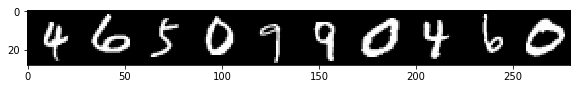

Corrupted Images


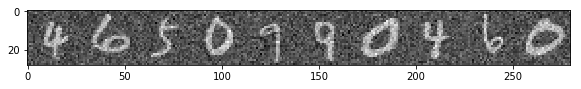

Reconstructed Images


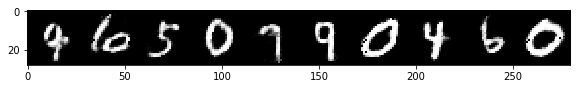

Test loss: 0.0190852

Epoch 191:
	Iteration 52387  	Loss: 0.0164121
	Iteration 52524  	Loss: 0.0163365
Epoch 192:
	Iteration 52662  	Loss: 0.0162943
	Iteration 52799  	Loss: 0.0161419
Epoch 193:
	Iteration 52937  	Loss: 0.0161677
	Iteration 53074  	Loss: 0.016101
Epoch 194:
	Iteration 53212  	Loss: 0.0152615
	Iteration 53349  	Loss: 0.0157803
Epoch 195:
	Iteration 53487  	Loss: 0.0159932
	Iteration 53624  	Loss: 0.0160949
Epoch 196:
	Iteration 53762  	Loss: 0.0162957
	Iteration 53899  	Loss: 0.0163494
Epoch 197:
	Iteration 54037  	Loss: 0.0165582
	Iteration 54174  	Loss: 0.015836
Epoch 198:
	Iteration 54312  	Loss: 0.0164081
	Iteration 54449  	Loss: 0.017034
Epoch 199:
	Iteration 54587  	Loss: 0.0163403
	Iteration 54724  	Loss: 0.0163438
Epoch 200:
	Iteration 54862  	Loss: 0.016464
	Iteration 54999  	Loss: 0.0162645
Original Images


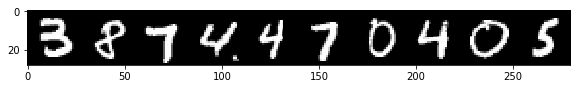

Corrupted Images


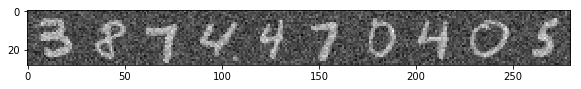

Reconstructed Images


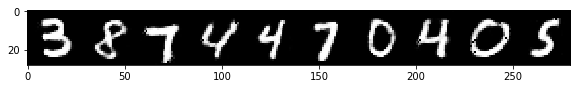

Test loss: 0.0158933



In [51]:
train_loss = []
test_loss = []
num_iterations = mnist.train.num_examples // batch_size
absolute_iterations_count = 1

for epoch in range(1, num_epochs + 1):
    print("Epoch " + str(epoch) + ":")

    for i in range(1, num_iterations + 1):
        batch_x, _ = mnist.train.next_batch(batch_size)
        _, l = sess.run([optimizer, loss], feed_dict={X: batch_x})
        train_loss.append(l)
        
        if i % (num_iterations // num_display_iterations) == 0:
            print("\tIteration " + str(absolute_iterations_count) + "  \tLoss: " + str(l))

        absolute_iterations_count += 1
            
    if epoch % (num_epochs // num_tests) == 0 or epoch == 1:
        testAE()

Was nun noch fehlt ist die Testfunktion, die beim obigen Training verwendet wurde. Wie bereits erläutert dient das Testen der Kontrolle, um zu prüfen, wie gut das Netz bei Eingaben arbeitet, die er nicht trainiert hat.

Da dieser Teil ein wenig mit dem Testen an sich und der Visualisierung des Testablaufes vermischt ist, wird er in zwei Erläuterungsschritte aufgeteilt. Die entsprechenden Codestellen wurden mit _`Testing`_ und _`Visualization`_ markiert.

### Testen
Zunächst wird eine Variable `n` angelegt, die angibt, wie viele Daten getestet werden sollen, also im Grunde die Batch Size für den Test. Als nächstes werden, ähnlich wie bei dem Training auch, die Testdaten mit `mnist.test.next_batch(n)` abgerufen und in `batch_x` gespeichert. Der Hauptunterschied zwischen Test und Training erfolt hier: Es wird mit `sess.run()` **nur** `loss` mit den Testdaten aus `batch_x` aufgerufen. Der Optimizer wird weggelassen, da die Testdaten nicht trainiert werden sollen und nur der Verlust bestimmt wird. Diesen Verlust können wir nun ausgeben um zu sehen, ob das Netz schlechter oder sogar besser mit unbekannten Daten arbeitet (in der Regel ist der Test wert ein wenig schlechter als der Trainingswert). Um diesen Vergleich besser visualisieren zu können nehmen wir diesen Verlustwert (wie auch die Trainingsverluste) in die Liste `test_loss` auf um sie später in einem Graph anzeigen zu können.

### Visualisierung
Zu Beginn werden drei Numpy-Arrays erstellt `canvas_orig`, `canvas_corrupt` und `canvas_recon`, mit den Dimensionen 28x(28\*n). Diese Abmessung kommt zu Stande, da die Testdaten (wie bei dem Training auch) 28x28 Pixel groß sind. In diesem Beispiel werden die 10 Testbilder (da `n = 10`) in einer Reihe nebeneinander angezeigt, somit benötigen wir `28` Pixel in der Y-Achse und `28 * n` Pixel in der X-Achse. Als nächste werden die rekonstruierten Bilder benötigt, die angezeigt werden sollen. Dafür wird die Berechnung des Verlustes aus dem Testen-Teil verwendet, indem `Y` auch mit `sess.run()` mit den Testdaten aus `batch_x` aufgerufen wird. Dies liefert die direkte Ausgabe des DAE und speichern sie in `g`. Nun liegen die Daten in einem eindimensionalen Array mit der Größe 748 (28 \* 28) vor, die jeweils noch umgeformt werden müssen. In einer Schleife wird über die Anzahl der Testdaten `n` iteriert um jedes Bild einzeln zu verarbeiten. Das Array `canvas_orig` soll das Originalbild enthalten, also wird mit `batch_x[i].reshape([28, 28])` das i-te Bild aus `batch_x` in die Form 28x28 Pixel gebracht und dann 'canvas_orig' an entsprechender Stelle (abhängig von `i`) zugewiesen. Für `canvas_corrput`, welches die korrupten Bilder enthalten soll, gilt selbiges mit der Ausnahme, dass das Bild aus `batch_x[i]` erst durch `corrupt()` korrumpiert werden muss. Mit `canvas_recon` wird ebenfalls entsprechend für die rekonstruierten Bilder verfahren, welche sich in `g` befinden. Zum Schluss werden die Bilder noch ausgegeben. Dazu wird Matplotlib (hier `plt`) verwendet. Für die Ausgaben werden die Parameter `origin="upper"` und `cmap="gray"` verwendet. Ersteres beschreibt, wo die Koordinate `[0, 0]` für das Array ist, aus dem das Bild gezeichnet werden soll. Da unser Array an der ersten Stelle den ersten Pixel oben links hat, wird hier `upper` verwendet. Letzteres wird verwendet, um das Bild schwarzweiß gefärbt.

In [50]:
def testAE():
    # Testing
    n = 10
    
    # Visualization
    canvas_orig = np.empty((28, 28 * n))
    canvas_corrupt = np.empty((28, 28 * n))
    canvas_recon = np.empty((28, 28 * n))
    
    # Testing
    batch_x, _ = mnist.test.next_batch(n)
    
    # Testing and Visualization
    g, l = sess.run([Y, loss], feed_dict={X: batch_x})
    test_loss.append(l)

    # Visialization
    for i in range(n):
        canvas_orig[0: 28, i * 28: (i + 1) * 28] = batch_x[i].reshape([28, 28])
        canvas_corrupt[0: 28, i * 28: (i + 1) * 28] = corrupt(batch_x[i]).reshape([28, 28])
        canvas_recon[0: 28, i * 28: (i + 1) * 28] = g[i].reshape([28, 28])    
    
    # Visualization
    print("Original Images")     
    plt.figure(figsize=(n, 1))
    plt.imshow(canvas_orig, origin="upper", cmap="gray")
    plt.show()
    
    print("Corrupted Images")     
    plt.figure(figsize=(n, 1))
    plt.imshow(canvas_corrupt, origin="upper", cmap="gray")
    plt.show()

    print("Reconstructed Images")
    plt.figure(figsize=(n, 1))
    plt.imshow(canvas_recon, origin="upper", cmap="gray")
    plt.show()
    
    print("Test loss: " + str(l) + "\n")

Zum Schluss werden noch die gespeicherten Verlustwerte in einem Graphen aus. Dafür werden die Variablen `y_train` und `y_test` erzeugt, welche die y-Werte des Graphen darstellen sollen. Da es deutlich weniger Testverluste gibt als Trainingsverluste, müssen die Abstände zwischen den Tests errechnet werden, damit sie mit den Trainingsverlusten übereinstimmen. So sollte der Testverlust nach dem beispielsweise 500. Trainingsverlust an selber Stelle im Graph auftauchen. Trainingswerte werden mit einer roten Linie (daher `r`, für _**r**ed_) und Testwerte mit schwarzen Punkten (daher `ko`, für _blac**k**_ das `o` für den Punkt) markiert.

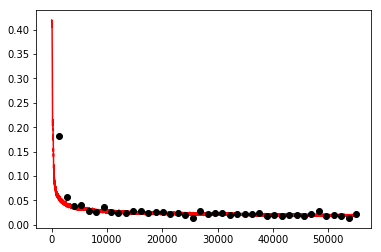

In [39]:
y_train = list(range(absolute_iterations_count-1))
y_test = [i * (absolute_iterations_count // (num_tests+1)) for i in range(1, num_tests + 2)]

plt.plot(y_train, train_loss, 'r', y_test, test_loss, 'ko')    
plt.show()

Somit erhalten wir einen voll funktionsfähigen Denoising Autoencoder.